# Image Segmentation in Tensorflow 2.0

> Experiment overview
> We will train a neural network to output a pixel-wise mask of the given image

## Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

![ImageSegmentation](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/image-segmentation.png)

### The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

### The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories

> Class 1 : Pixel belonging to the pet

> Class 2 : Pixel bordering the pet

> Class 3 : None of the above/ Surrounding pixel

In [1]:
import tensorflow as tf
from tensorflow_examples.tensorflow_examples.models.pix2pix import pix2pix # Manually install 

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import platform
import datetime
import os
import math
import random
import pathlib

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tensorboard

Python version: 3.7.6
Tensorflow version: 2.2.0
Keras version: 2.3.0-tf


In [2]:
# checking current directory
pathlib.Path.cwd()

WindowsPath('C:/Users/bokhy/Desktop/Python/Python-Projects/Tensorflow')

# 1. Load Data
##### https://www.tensorflow.org/datasets/overview

In [3]:
builder = tfds.builder('oxford_iiit_pet:3.1.0')
info = builder.info
print(info)
# by setting register_checksums as True to pass the check
config = tfds.download.DownloadConfig(register_checksums = True)
builder.download_and_prepare(download_config=config)
dataset = builder.as_dataset()

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.1.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [4]:
dataset['train']

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [6]:
NUM_TRAIN_EXAMPLES = info.splits['train'].num_examples
NUM_TEST_EXAMPLES = info.splits['test'].num_examples
NUM_CLASSES = info.features['label'].num_classes

# 2. Re-size / Augment Image

In [7]:
def normalize(input_image, input_mask):
    # Normalized to [0,1]
    input_image = tf.cast(input_image, tf.float32) / 255.0
    # pixels in the segmentation mask are labeled either {1, 2, 3}, but let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2} 
    input_mask -= 1
    return input_image, input_mask

In [8]:
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    # flip image for train-set
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [9]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# 3. Train/Test Split and Batch in Loader

In [12]:
# Train/Test Split
NUM_TRAIN_EXAMPLES = info.splits['train'].num_examples
NUM_TEST_EXAMPLES = info.splits['test'].num_examples
NUM_CLASSES = info.features['label'].num_classes
print("train length:", NUM_TRAIN_EXAMPLES)
print("test length:", NUM_TEST_EXAMPLES)
print("NUM_CLASSES:", NUM_TRAIN_EXAMPLES)

train length: 3680
test length: 3669
NUM_CLASSES: 3680


In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = NUM_TRAIN_EXAMPLES # Usually use the number of train examples

In [14]:
train = dataset['train'].map(load_image_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [15]:
train_dataset = train.cache().shuffle(
    buffer_size = BUFFER_SIZE
)
train_dataset = train.batch(
    batch_size = BATCH_SIZE
).repeat()

# Prefetch enables the input pipeline to asynchronously fetch batches while your model is training.
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


# 4. EDA

In [19]:
def display(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        #plt.axis('off')
    plt.show()

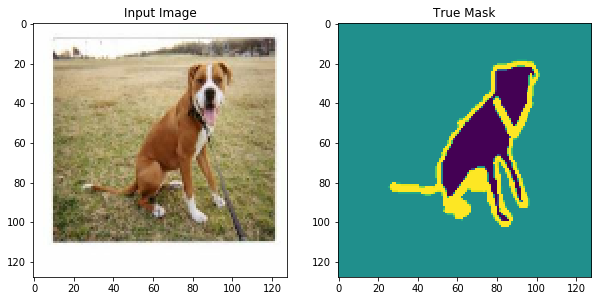

In [20]:
# Check for any sample image by changing number in 'take'
for image, mask in train.take(6): 
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# 5. Create a Model 

### The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the Pix2pix tutorial.

In [21]:
# RGB has 3 channels (Red, Green, Blue)
OUTPUT_CHANNELS = 3 

In [23]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[128, 128, 3], 
    include_top=False,
    weights='imagenet', # If None, random initialization
    pooling='avg' # If None, output of the model will be the 4D tensor output of the last convolutional block. If max, global max pooling will be applied
)

base_model.summary()

9412608/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
________________

In [24]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# The encoder (Down-stack) consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [25]:
# The decoder (Up-stack) is simply a series of upsample blocks
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [26]:
def MyModel(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Encoder 
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Decoder and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# 6. Train the Model

In [29]:
# The reason to use "SparseCategoricalCrossentropy" is because the network is trying to assign each pixel a label, just like multi-class prediction. 
# In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class
model = MyModel(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Let's try out the model to see what it predicts before training.

In [30]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [31]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
        else:
            display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

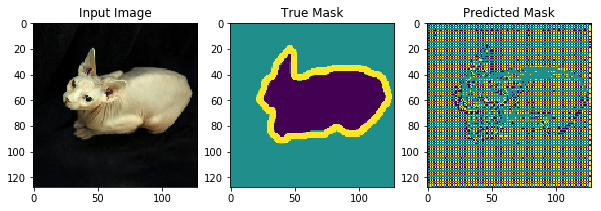

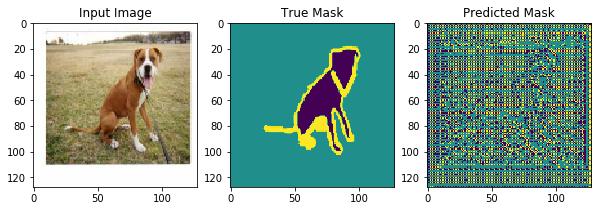

In [33]:
show_predictions(train_dataset)

## Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below.

In [34]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [35]:
EPOCHS = 20
STEPS_PER_EPOCH = NUM_TRAIN_EXAMPLES // BATCH_SIZE
VALIDATION_STEPS = NUM_TEST_EXAMPLES // BATCH_SIZE if NUM_TEST_EXAMPLES // BATCH_SIZE else 1

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset, # Already included testset as a validation data
                          callbacks=[DisplayCallback()])


Sample Prediction after epoch 20

57/57 [==============================] - 254s 4s/step - loss: 0.1846 - accuracy: 0.9183 - val_loss: 0.2893 - val_accuracy: 0.8909


In [38]:
def render_training_history(model_history):
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

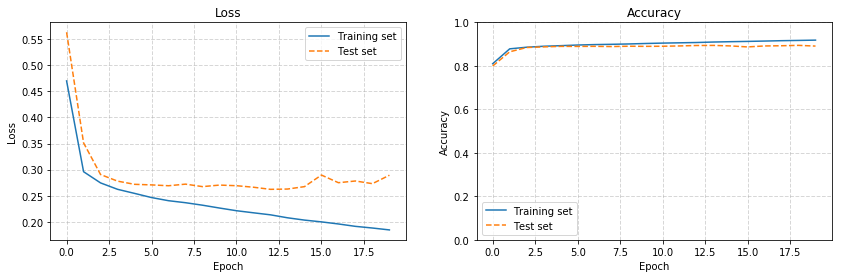

In [39]:
render_training_history(model_history)

# 7. Make Predictions

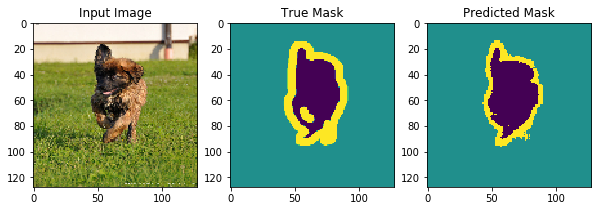

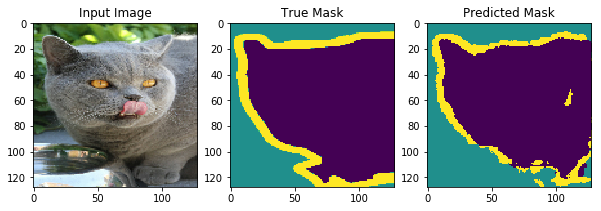

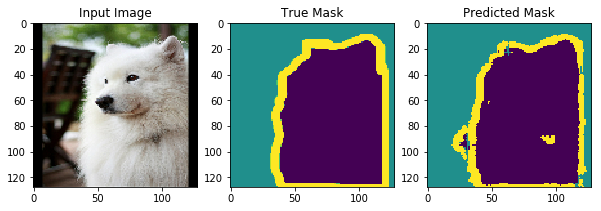

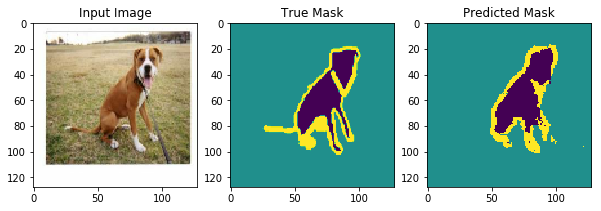

In [40]:
show_predictions(test_dataset, 3)